## NEVER FORGET
  1. test all functions you made
  1. sign of anything wrong, dont ignore it,  
  1. start at least notes/graphs for thesis report 



## Todos:
  1. 10k buffer -> visible that on small buffer non 100% is better as otherwise probably catastrophic forgetting, 
  1. check also with smaller/shorter epsilon, maybe also rnd exploration


## Agents atm:
  1. go towards state goal until value function stops increasing
  1. framestack on uvf network, 
  1. 2 networks 



## Questions to ask: 
  1. buffer size 500k fr? isnt that the whole experience - for my experiment use smaller buffer (20-50k ca)
  1. learning_starts? default (50k) or 0? - batch size
  1. for performance reasons would it make sense to make the states we want to start from a stack that gets updated whenever its either empty or regularily?   
    otherwise a lot of repeated computation and complicated structure 
     - stack makes sense 
  1. forgot, should tp move to unreachable states? or rather just load position of player? (currently just loads state got from buffer)
     - agent position (cause edge case where buffer only one level as impossible to leave)
  1. should RND be trained on whole buffer or just the ones we sampled or just the ones we sampled an kept? 
     - either train from sample from buffer or what you have seen in environment 


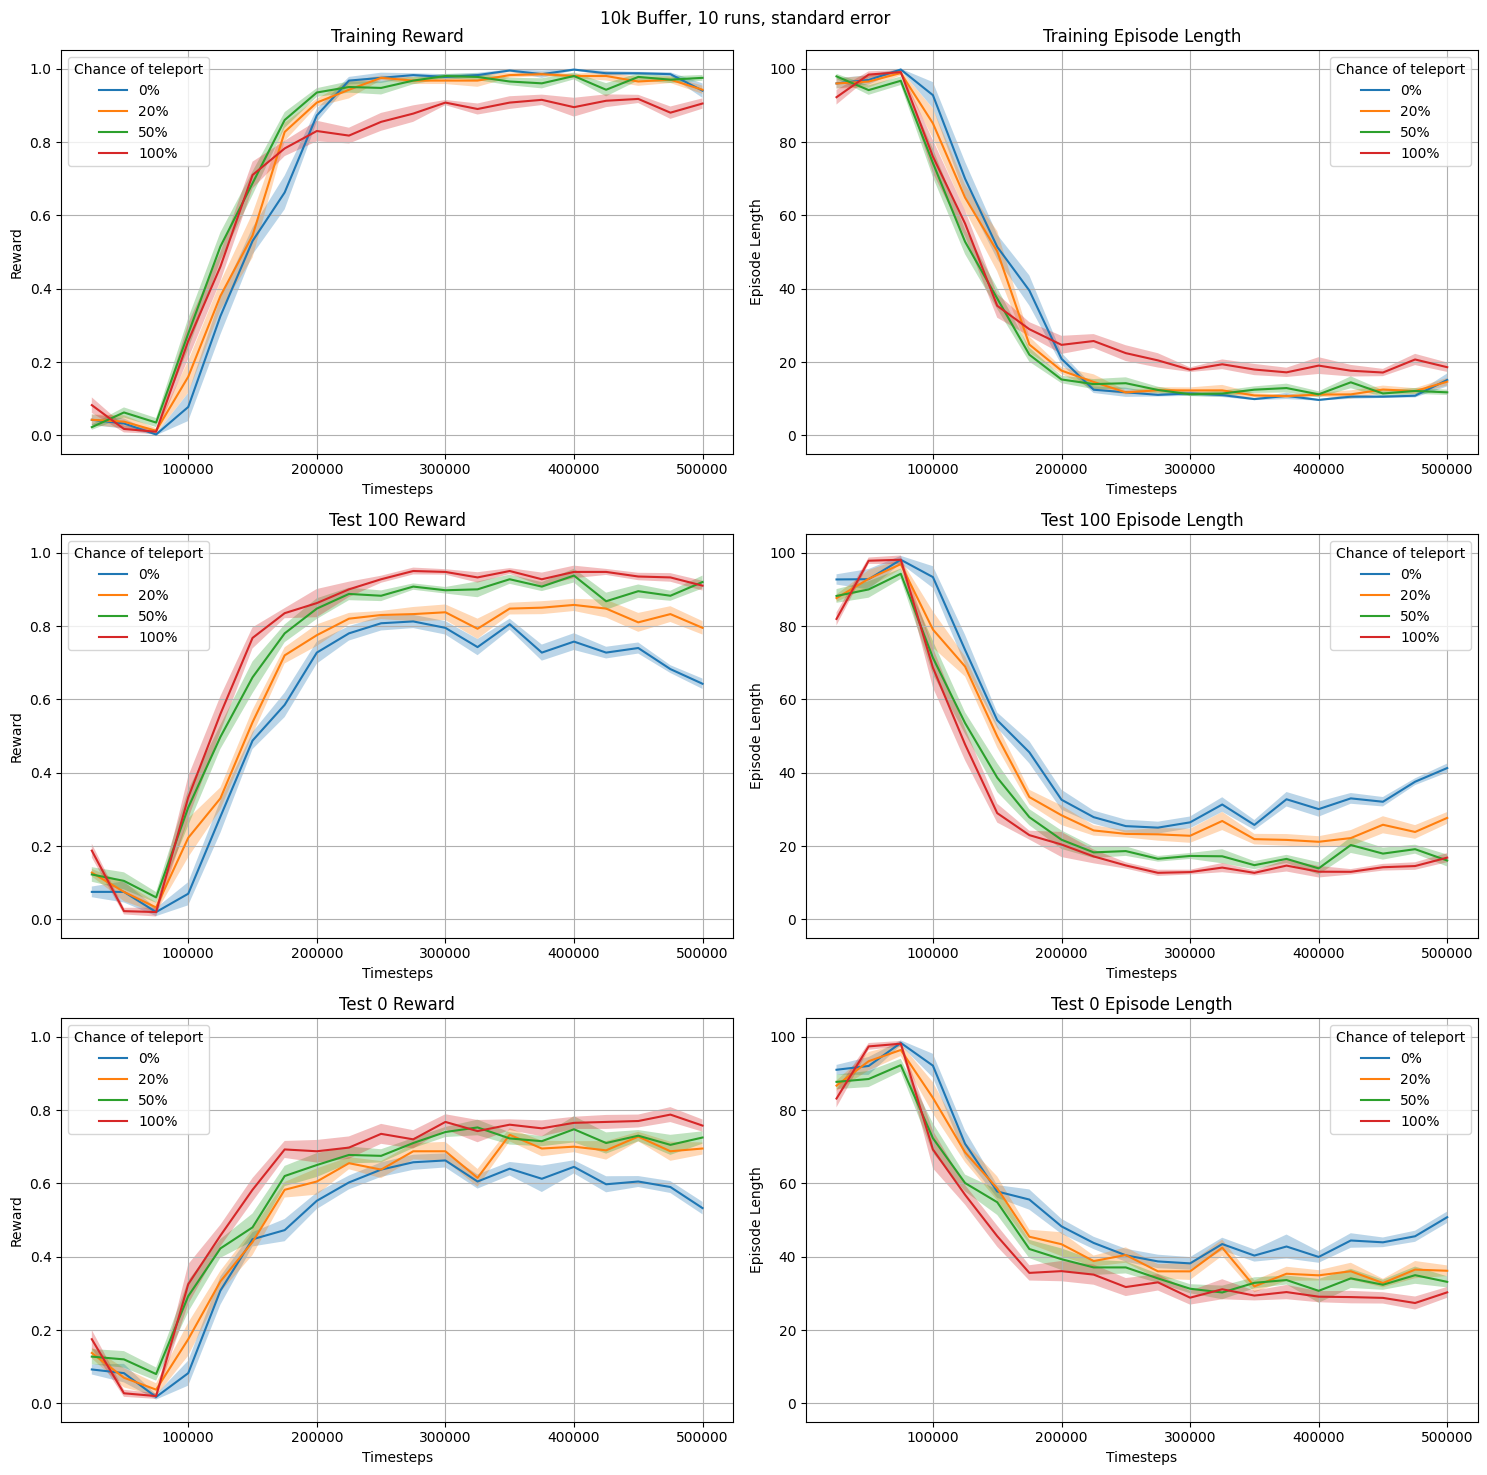

In [6]:
### Visualizing tp chance on exploration 1.0

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np 

buffersize=10 #in k
runs=10

base_log=f'./logs/tpchance_b{buffersize}k'

def load_data(env, name):
    tmp=[np.load(f"{base_log}/{name}_{name}/{env}/{i}/evaluations.npz") for i in range(0,runs)]
    dt={}
    dt['results']=np.array([np.mean(i['results'],axis=1) for i in tmp])
    dt['ep_lengths']=np.array([np.mean(i['ep_lengths'],axis=1) for i in tmp])
    dt['timesteps']=tmp[0]['timesteps']
    return dt


cmap=mpl.colormaps['tab10']
colors={}

def plot(ax, dt, title,name, ylabel, ydata, type='se'):
    data=dt[ydata]


    name=f"{round(float(name)*100)}%"

    if ylabel=='Reward':
        ax.set_ylim(-0.05,1.05)
    else:
        ax.set_ylim(-5,105)

    if type=='std': #standard deviation
        mean=np.mean(data,axis=0)
        std=np.std(data,axis=0)

        ax.plot(dt['timesteps'],mean, label=name)
        ax.fill_between(dt['timesteps'],mean-std,mean+std,alpha=0.3)
    elif type=='ci': #confidence interval
        mean=np.mean(data,axis=0)
        ci=np.percentile(data,[2.5,97.5],axis=0)

        ax.plot(dt['timesteps'],mean, label=name)
        ax.fill_between(dt['timesteps'],ci[0],ci[1],alpha=0.3)
    elif type=='se': #standard error 
        mean=np.mean(data,axis=0)
        se=np.std(data,axis=0)/np.sqrt(data.shape[0])

        ax.plot(dt['timesteps'],mean, label=name)
        ax.fill_between(dt['timesteps'],mean-se,mean+se,alpha=0.3)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Timesteps')
    ax.legend(title='Chance of teleport')
    ax.grid(True)

fig, ax = plt.subplots(3,2, figsize=(15,15))

fig.suptitle(f"{buffersize}k Buffer, {runs} runs, standard error")


for name in ['0.0','0.2','0.5','1']:
    results={}
    for env in ['tr', '0', '100']:
        results[env]=load_data(env,name)
    

    plot(ax[0,0],results['tr'], 'Training Reward',name,'Reward','results')
    plot(ax[0,1],results['tr'], 'Training Episode Length',name, 'Episode Length','ep_lengths')

    plot(ax[1,0],results['100'], 'Test 100 Reward',name,'Reward','results')
    plot(ax[1,1],results['100'], 'Test 100 Episode Length',name, 'Episode Length','ep_lengths')

    plot(ax[2,0],results['0'], 'Test 0 Reward',name,'Reward','results')
    plot(ax[2,1],results['0'], 'Test 0 Episode Length',name, 'Episode Length','ep_lengths')

plt.tight_layout()

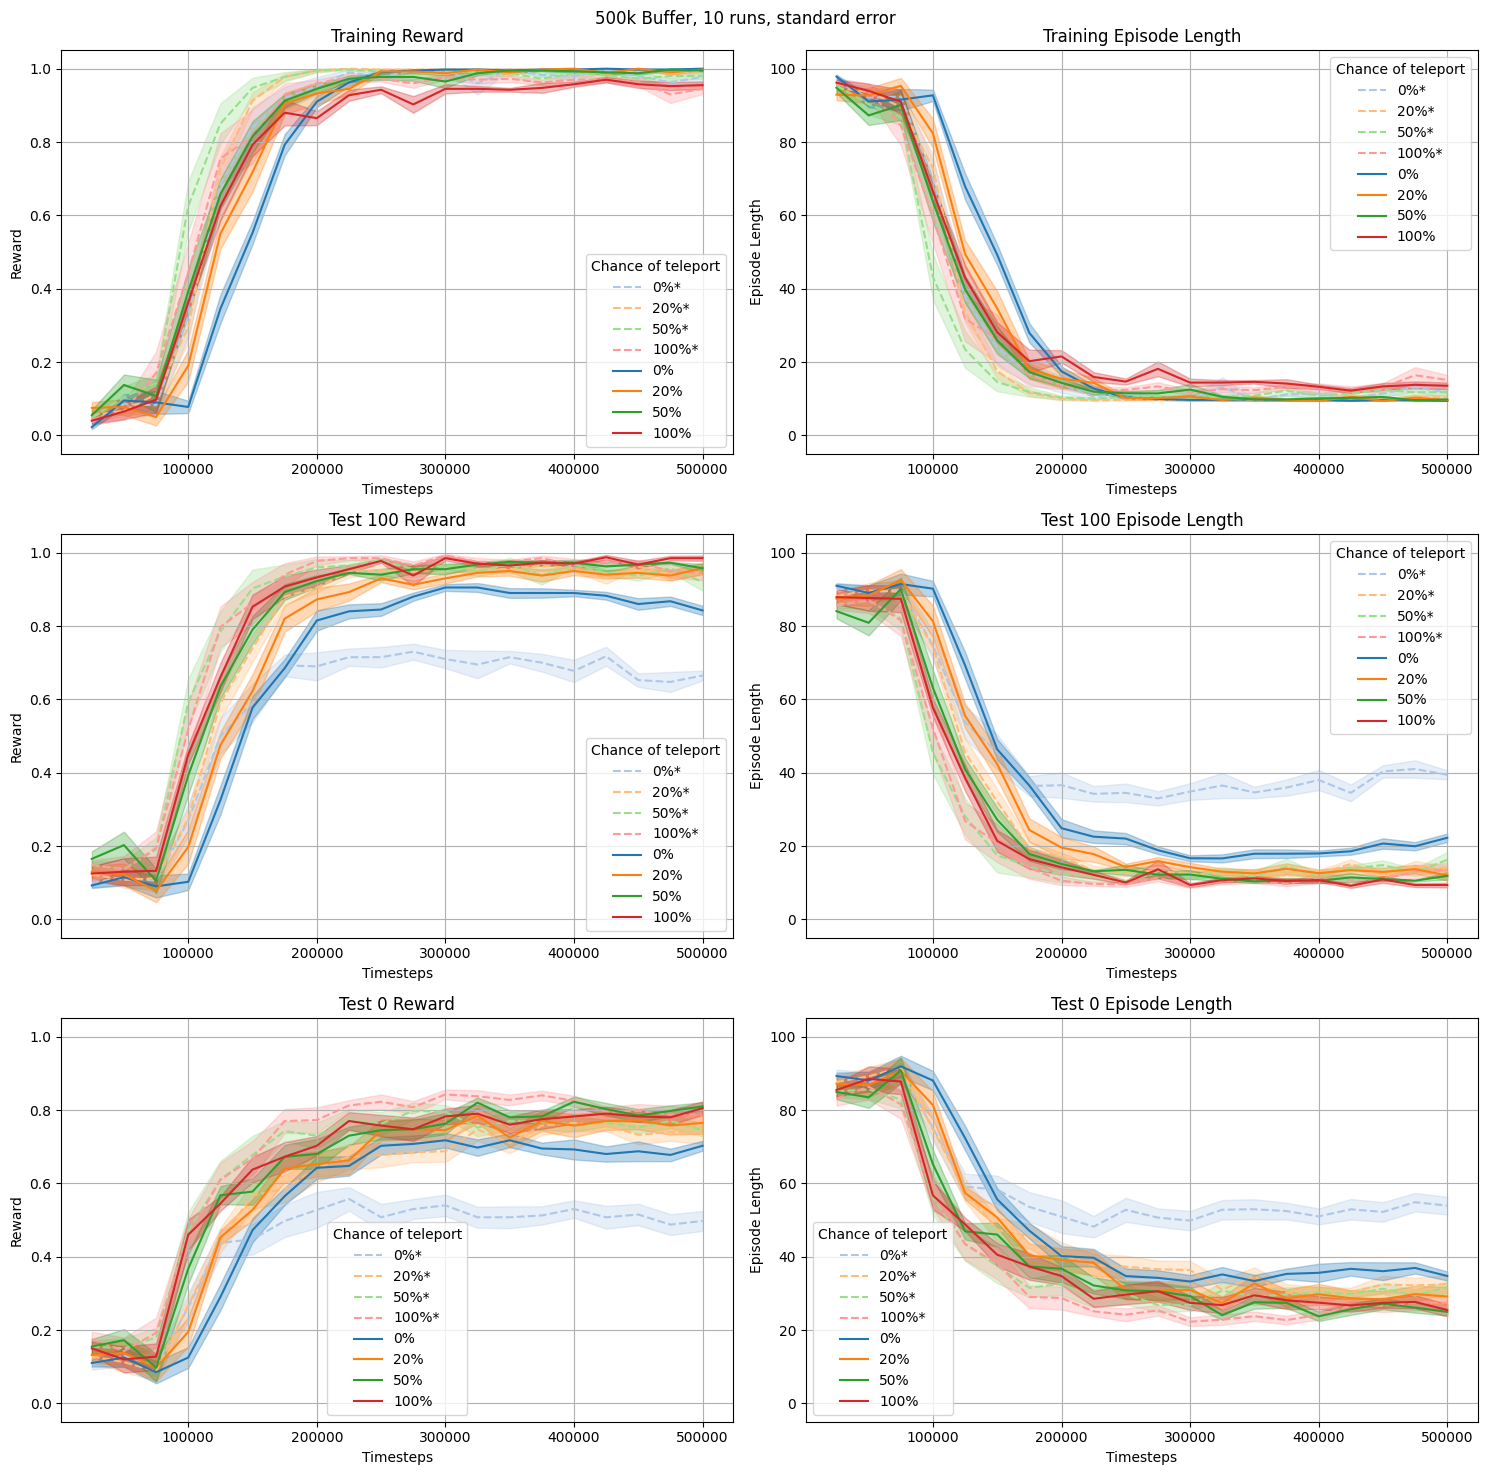

In [3]:
### Visualizing Exploration frac 

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np 

buffersize=500 #in k
runs=10

base_log=f'./logs/tpchance_b{buffersize}k'

def load_data(env, name, epsilon=1.0):
    if epsilon==1.0:
        tmp=[np.load(f"{base_log}/{name}_{name}/{env}/{i}/evaluations.npz") for i in range(0,runs)]
    else:
        tmp=[np.load(f"{base_log}/{name}_{name}_e0{round(epsilon*10)}/{env}/{i}/evaluations.npz") for i in range(0,runs)]
    dt={}
    dt['results']=np.array([np.mean(i['results'],axis=1) for i in tmp])
    dt['ep_lengths']=np.array([np.mean(i['ep_lengths'],axis=1) for i in tmp])
    dt['timesteps']=tmp[0]['timesteps']
    return dt


cmap=mpl.colormaps['tab20']
colors={}

def plot(ax, dt, title,name, ylabel, ydata, type='se', extra={}):
    data=dt[ydata]

    
    if name not in colors:
        colors[name]=len(colors)*2

    color=cmap(colors[name])


    style='-'

    if "dashed" in extra:
        style='--'
        color=cmap(colors[name]+1)


    labe=f"{round(float(name)*100)}%"

    if "suffix" in extra:
        labe+=extra['suffix']

    if ylabel=='Reward':
        ax.set_ylim(-0.05,1.05)
    else:
        ax.set_ylim(-5,105)

    if type=='std': #standard deviation
        mean=np.mean(data,axis=0)
        std=np.std(data,axis=0)

        ax.plot(dt['timesteps'],mean, label=labe, color=color, linestyle=style)
        ax.fill_between(dt['timesteps'],mean-std,mean+std,alpha=0.3, color=color)
    elif type=='ci': #confidence interval
        mean=np.mean(data,axis=0)
        ci=np.percentile(data,[2.5,97.5],axis=0)

        ax.plot(dt['timesteps'],mean, label=labe, color=color, linestyle=style)
        ax.fill_between(dt['timesteps'],ci[0],ci[1],alpha=0.3, color=color)
    elif type=='se': #standard error 
        mean=np.mean(data,axis=0)
        se=np.std(data,axis=0)/np.sqrt(data.shape[0])

        ax.plot(dt['timesteps'],mean, label=labe, color=color, linestyle=style)
        ax.fill_between(dt['timesteps'],mean-se,mean+se,alpha=0.3, color=color)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Timesteps')
    ax.legend(title='Chance of teleport')
    ax.grid(True)

fig, ax = plt.subplots(3,2, figsize=(15,15))

fig.suptitle(f"{buffersize}k Buffer, {runs} runs, standard error")

for eps in [0.1,1.0]:
    for name in ['0.0','0.2','0.5','1']:
        results={}
        for env in ['tr', '0', '100']:
            results[env]=load_data(env,name,eps)
        
        extra={}
        if eps==0.1:
            extra['suffix']='*'
            extra['dashed']=True

        plot(ax[0,0],results['tr'], 'Training Reward',name,'Reward','results', extra=extra)
        plot(ax[0,1],results['tr'], 'Training Episode Length',name, 'Episode Length','ep_lengths', extra=extra)

        plot(ax[1,0],results['100'], 'Test 100 Reward',name,'Reward','results', extra=extra)
        plot(ax[1,1],results['100'], 'Test 100 Episode Length',name, 'Episode Length','ep_lengths', extra=extra)

        plot(ax[2,0],results['0'], 'Test 0 Reward',name,'Reward','results', extra=extra)
        plot(ax[2,1],results['0'], 'Test 0 Episode Length',name, 'Episode Length','ep_lengths', extra=extra)

plt.tight_layout()